In [1]:
# https://ai.google/tools/datasets/google-facial-expression/
import imageio
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
import time
import numpy as np
import random
import hashlib
from skimage.transform import resize
import math
import pickle
import signal

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
train_df = pd.read_csv('FEC_dataset/two_class_ready.csv')
train_df.head()
# hyperparams
SHAPE=(160,160,3)

In [4]:
def TripletGen(data, root='FEC_dataset/formatted', batch_size=128, rescale=1./255, shape=SHAPE[:2]):
    # yielding format must be [anchorlist, positlist, negatlist], dummy
    # 3 elements of shape (@batch_size,*@shape) in the list and an empty np.array of shape(@batch_size,1)
    
    ## the init code
    n = len(data)
    iterations = math.ceil(n/batch_size)
    print(f"Found {n} triplets in the dataset")
    
    def genFunc(batch_size = batch_size):
        y_dummy = np.empty((batch_size,))
        while True:
            for i in range(iterations):
                # use start and end as indices to work with
                start, end = i*batch_size, min((i+1)*batch_size, n)
                batch_size_eff = end - start

                arr_shape = (batch_size_eff, *shape, 3)
                anchor = np.empty(arr_shape)
                positive = np.empty(arr_shape)
                negative = np.empty(arr_shape)

                for arr_index in range(batch_size_eff):
                    data_index = arr_index + start

                    # anchor
                    path = os.path.join(root, data["Image1"][data_index])
                    temp = image.load_img( path, target_size = shape )
                    anchor[arr_index] = image.img_to_array(temp)*rescale

                    # positive
                    path = os.path.join(root, data["Image2"][data_index])
                    temp = image.load_img( path, target_size = shape )
                    positive[arr_index] = image.img_to_array(temp)*rescale

                    # negative
                    path = os.path.join(root, data["Image3"][data_index])
                    temp = image.load_img( path, target_size = shape )
                    negative[arr_index] = image.img_to_array(temp)*rescale

                yield [anchor, positive, negative], y_dummy[:batch_size_eff]
    return genFunc(), iterations

imgs, iterations = TripletGen(train_df)
print("Before loop")
print("=="*18)

for i in range(5):
    left, right = next(imgs)
    for i, thing in enumerate(left):
        print(f"{i+1}th element: ",thing.shape)
    print("dummy", right.shape)
    print("=-"*18)
    
del(imgs)

Found 136379 triplets in the dataset
Before loop
1th element:  (128, 160, 160, 3)
2th element:  (128, 160, 160, 3)
3th element:  (128, 160, 160, 3)
dummy (128,)
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
1th element:  (128, 160, 160, 3)
2th element:  (128, 160, 160, 3)
3th element:  (128, 160, 160, 3)
dummy (128,)
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
1th element:  (128, 160, 160, 3)
2th element:  (128, 160, 160, 3)
3th element:  (128, 160, 160, 3)
dummy (128,)
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
1th element:  (128, 160, 160, 3)
2th element:  (128, 160, 160, 3)
3th element:  (128, 160, 160, 3)
dummy (128,)
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
1th element:  (128, 160, 160, 3)
2th element:  (128, 160, 160, 3)
3th element:  (128, 160, 160, 3)
dummy (128,)
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


In [5]:
def batch_tf_triplet_loss(y_true, y_pred, alpha=0.4):
    n = y_pred.shape.as_list()[-1]
    anchor = y_pred[:,0:n//3]
    positive = y_pred[:,n//3:2*n//3]
    negative = y_pred[:,2*n//3:n]
    
    sigma_pd = tf.math.reduce_sum(tf.norm(positive-anchor, axis=1))
    sigma_nd = tf.math.reduce_sum(tf.norm(negative-anchor, axis=1))

    loss = sigma_nd - sigma_pd + alpha
    return tf.math.log(1.0+tf.math.exp(loss))
#     return tf.math.maximum(loss, 0)

In [6]:
l2 = tf.keras.regularizers.l2
alpha = 0
base_model = Sequential([
    #first convolution
    Conv2D(16, (3,3), activation='relu', input_shape=SHAPE),#, activity_regularizer=l2(alpha)),
    MaxPool2D(2,2),
    #second
    Conv2D(32, (3,3), activation='relu'),#, activity_regularizer=l2(alpha)),
    MaxPool2D(2,2),
    #third
    Conv2D(64, (3,3), activation='relu'),#, activity_regularizer=l2(alpha)),
    MaxPool2D(2,2),
    #fourth
    Conv2D(64, (3,3), activation='relu'),#, activity_regularizer=l2(alpha)),
    MaxPool2D(2,2),
    #fifth
    Conv2D(64, (3,3), activation='relu'),#, activity_regularizer=l2(alpha)),
    MaxPool2D(2,2),
    # hidden
    Flatten(),
    Dense(1024, activation='softplus'),#, activity_regularizer=l2(alpha)),
    #Last layer
    Dense(16, activation='tanh')
])
anchor_input = Input(SHAPE, name='anchor_input')
positive_input = Input(SHAPE, name='positive_input')
negative_input = Input(SHAPE, name='negative_input')

encoded_anchor = base_model(anchor_input)
encoded_positive = base_model(positive_input)
encoded_negative = base_model(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

train_model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
train_model.summary()

W0907 20:50:16.701715 139631116175168 deprecation.py:506] From /home/deepak/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16)           704688      anchor_input[0][0]               
                                                                 positive_input[0][0]         

In [7]:
mySGD = SGD(nesterov=True)
train_model.compile(loss=batch_tf_triplet_loss, optimizer=mySGD)
train, steps = TripletGen(train_df, batch_size=128)
checkpoint = ModelCheckpoint("emotion.hdf5", monitor='loss', verbose=1, save_best_only=True, mode='min')

Found 136379 triplets in the dataset


In [8]:
# just to get a taste of the model
# 1.0238742
# m, b = 120, 120
# dgen, dsteps = TripletGen(train_df[:m], batch_size=b)
# x = []
# for i, (images, dy) in tqdm(enumerate(dgen)):
#     if i< math.ceil(m//b):
#         x.append(train_model.predict(images))
#     else: 
#         break
# print(len(x))
# loss = tf.Variable(tf.zeros([1]))
# for i, num in enumerate(x):
#     loss = loss + batch_tf_triplet_loss(None, tf.convert_to_tensor(num, np.float32))
# print("before sess")
# with tf.Session() as sess:
#     init_op = tf.global_variables_initializer()
#     sess.run(init_op)
#     with sess.as_default():
#         print(sess.run(loss))

In [ ]:
history = train_model.fit_generator(train, epochs=100, steps_per_epoch=steps, callbacks=[checkpoint])

Epoch 1/100
1065/1066 [============================>.] - ETA: 0s - loss: 0.9131
Epoch 00001: loss did not improve from 0.91298
1066/1066 [==============================] - 760s 713ms/step - loss: 0.9131
Epoch 2/100
1065/1066 [============================>.] - ETA: 0s - loss: 0.9140
Epoch 00002: loss did not improve from 0.91298
1066/1066 [==============================] - 760s 713ms/step - loss: 0.9140
Epoch 3/100
1065/1066 [============================>.] - ETA: 0s - loss: 0.9138
Epoch 00003: loss did not improve from 0.91298
1066/1066 [==============================] - 763s 716ms/step - loss: 0.9138
Epoch 4/100
1065/1066 [============================>.] - ETA: 0s - loss: 0.9131
Epoch 00004: loss did not improve from 0.91298
1066/1066 [==============================] - 759s 712ms/step - loss: 0.9131
Epoch 5/100
1065/1066 [============================>.] - ETA: 0s - loss: 0.9130
Epoch 00005: loss did not improve from 0.91298
1066/1066 [==============================] - 760s 713ms/step 

Epoch 41/100
1065/1066 [============================>.] - ETA: 0s - loss: 0.9131
Epoch 00041: loss did not improve from 0.91129
1066/1066 [==============================] - 684s 641ms/step - loss: 0.9131
Epoch 42/100
1065/1066 [============================>.] - ETA: 0s - loss: 0.9130
Epoch 00042: loss did not improve from 0.91129
1066/1066 [==============================] - 684s 642ms/step - loss: 0.9130
Epoch 43/100
1065/1066 [============================>.] - ETA: 0s - loss: 0.9130
Epoch 00043: loss did not improve from 0.91129
1066/1066 [==============================] - 684s 641ms/step - loss: 0.9130
Epoch 44/100
1065/1066 [============================>.] - ETA: 0s - loss: 0.9130
Epoch 00044: loss did not improve from 0.91129
1066/1066 [==============================] - 684s 642ms/step - loss: 0.9130
Epoch 45/100
1065/1066 [============================>.] - ETA: 0s - loss: 0.9130
Epoch 00045: loss did not improve from 0.91129
1066/1066 [==============================] - 684s 641ms/

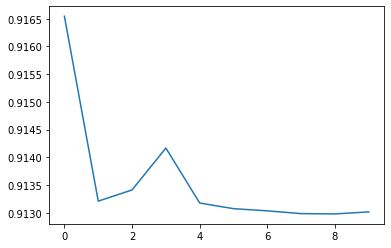

In [10]:
# os.kill(os.getpid(), signal.SIGKILL)
plt.plot(history.history['loss'])

In [ ]:
train_model.save_weights("model.h5")
# print("Saved model to disk")
seq = train_model.layers[3]
seq.layers[6]#.get_weights()

In [ ]:
model = Model(inputs=[anchor_input], outputs=encoded_anchor)
model.load_weights("model.h5")
print("Loaded weights from h5 file")

In [ ]:
train, steps = TripletGen(train_df[:1], batch_size=1)
images, _ = next(train)
anchor, positive, negative = tuple(images)
print(anchor.shape)
# a,p,n = train_model.predict(anchor), model.predict(positive), model.predict(negative)
train_model.predict(images)